In [67]:
import random
import networkx as nx
import json

def generate_erdos_renyi_graph(n, p, seed=42):
    rng = random.Random(seed)
    edges = {i: [] for i in range(n)}
    for i in range(n):
        for j in range(i + 1, n):
            if rng.random() < p:
                edges[i].append(j)
                edges[j].append(i)
    return nx.Graph(edges)


def generate_ssbm_graph(n, k, A, B, seed=42):
    rng = random.Random(seed)
    community_assignments = [rng.randrange(k) for _ in range(n)]
    W = [[A if i == j else B for j in range(k)] for i in range(k)]

    edges = {i: [] for i in range(n)}
    for i in range(n):
        for j in range(i + 1, n):
            threshold = W[community_assignments[i]][community_assignments[j]]
            if rng.random() < threshold:
                edges[i].append(j)
                edges[j].append(i)

    return nx.Graph(edges), community_assignments

def create_web_graph(n):
    neighbors = {}
    with open ('../hw1/crawler144/10k.jsonl', 'r') as f:
        for line in f.readlines()[:n]:
            data = json.loads(line)
            neighbors[data['url']] = set(data['children'] if data['children'] is not None else [])

    valid_urls = set(neighbors.keys())
    for url in neighbors:
        if url in neighbors[url]:
            neighbors[url].remove(url)
        neighbors[url] = neighbors[url] & valid_urls
        
    web_graph = nx.Graph(neighbors)
    return web_graph

In [68]:
import matplotlib.pyplot as plt
import numpy as np

def plot_graph(graph, title):
    pos = nx.spring_layout(graph, seed=42)
    nx.draw_networkx(graph, pos=pos, with_labels=False, node_size=50, edge_color='silver')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Note: couldn't find a reverse spring layout in networkx, so I used Claude to implement this
def reverse_spring_layout(graph, iterations=500, seed=42, 
                          attraction=0.01, repulsion=0.5, damping=0.9):
    """
    Physics simulation with reversed forces:
    - All nodes attract each other (gravity toward center of mass)
    - Connected nodes (edges) repel each other
    """
    rng = np.random.default_rng(seed)
    nodes = list(graph.nodes())
    n = len(nodes)
    node_idx = {node: i for i, node in enumerate(nodes)}
    
    # Initialize random positions
    pos = rng.uniform(-1, 1, (n, 2))
    vel = np.zeros((n, 2))
    
    edges = [(node_idx[u], node_idx[v]) for u, v in graph.edges()]
    
    for _ in range(iterations):
        forces = np.zeros((n, 2))
        
        # Global attraction: all nodes pull toward center of mass
        center = pos.mean(axis=0)
        for i in range(n):
            direction = center - pos[i]
            dist = np.linalg.norm(direction)
            if dist > 0.001:
                forces[i] += attraction * direction
        
        # Edge repulsion: connected nodes push apart
        for i, j in edges:
            diff = pos[j] - pos[i]
            dist = np.linalg.norm(diff)
            if dist > 0.001:
                force = repulsion / (dist * dist) * (diff / dist)
                forces[i] -= force
                forces[j] += force
        
        # Update velocities and positions
        vel = damping * vel + forces
        pos += vel
    
    # Normalize to [-1, 1] range
    pos -= pos.min(axis=0)
    pos /= pos.max()
    pos = 2 * pos - 1
    
    return {node: tuple(pos[i]) for i, node in enumerate(nodes)}

def plot_ssbm_graph(graph, community_assignments, title):
    pos = reverse_spring_layout(graph, iterations=500, seed=42)
    node_colors = [community_assignments[node] for node in graph.nodes()]
    nx.draw_networkx(graph, pos=pos, with_labels=False, node_size=50, 
                     node_color=node_colors, cmap=plt.cm.tab10, edge_color='silver', alpha=0.7)
    plt.title(title)
    plt.axis('off')
    plt.show()

def plot_web_graph(graph, title):
    pos = nx.spring_layout(graph, seed=42)
    nx.draw_networkx(graph, pos=pos, with_labels=False, node_size=20, 
                     edge_color='silver', alpha=0.3)
    plt.title(title)
    plt.axis('off')
    plt.show()


# 2a

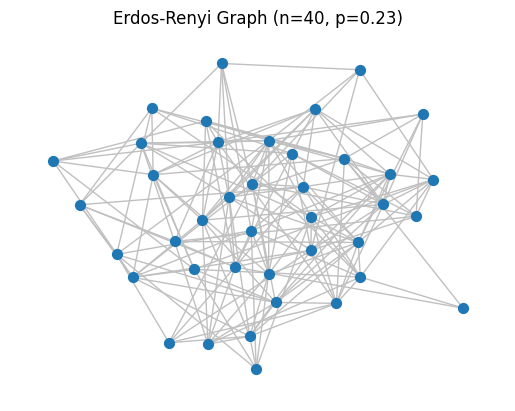

In [69]:
n = 40
erdos_renyi_graph = generate_erdos_renyi_graph(n, 0.23, seed=42)
plot_graph(erdos_renyi_graph, f"Erdos-Renyi Graph (n={40}, p={0.23})")

# 2b

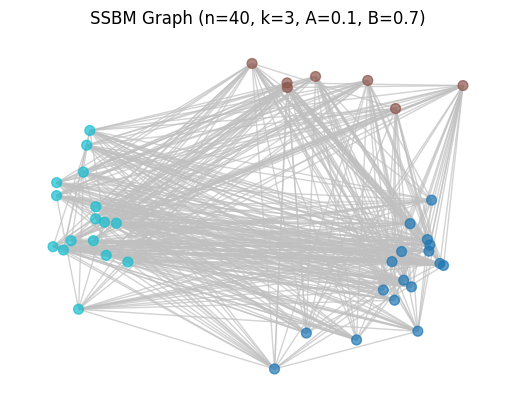

In [70]:
n = 40
k = 3
A = 0.1
B = 0.7
ssbm_graph, community_assignments = generate_ssbm_graph(n, k, A, B, seed=42)
plot_ssbm_graph(ssbm_graph, community_assignments, f"SSBM Graph (n={n}, k={k}, A={A}, B={B})")

# 2c

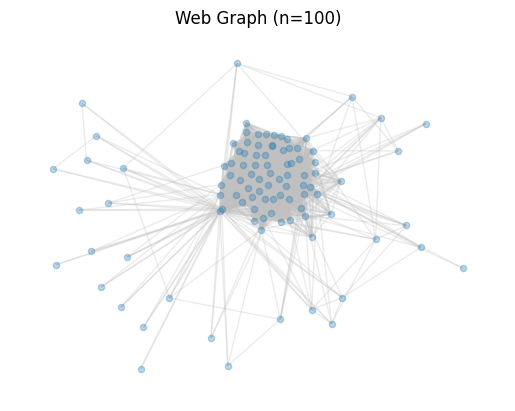

In [71]:
n = 100
web_graph_100 = create_web_graph(n)
plot_web_graph(web_graph_100, f"Web Graph (n={n})")

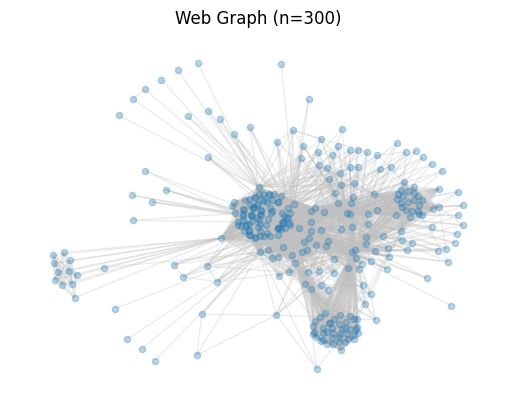

In [72]:
n = 300
web_graph_300 = create_web_graph(n)
plot_web_graph(web_graph_300, f"Web Graph (n={n})")
